In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import *
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.rm'] = 'Palatino'
#matplotlib.rcParams['mathtext.it'] = 'Palatino:italic'
#matplotlib.rcParams['mathtext.bf'] = 'Palatino:bold'

matplotlib.rcParams["figure.dpi"] = 200

from _context import vidlu
from vidlu.utils.presentation.figstyle import configure

get_figsize = configure(document_fontsize=9, font_package='palatino')

os.makedirs('./data/plots/', exist_ok=True)

### Half-resolution Cityscapes: teachers, perturbation models, algorithms

In [2]:
def ms(m, s):
    return dict(mean=m, std=s)


def plot_label_subsets(name_to_values, name_to_style, xticks=["$1/8$", "$1/4$", "$1/2$", "$1/1$"],
                       xlabel='Proportion of labels used', ylabel='$\mathrm{mIoU}/\%$', ylim=None, legend_loc='best'):
    w, h = get_figsize(0.8*0.8)

    fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(w, h))
    ax1.set_axisbelow(True)
    ax1.grid(color='#eee')

    for name, values in name_to_values.items():
        x = list(range(len(values)))
        style = {'color': 'C0', **name_to_style[name]}
        if isinstance(values[0], dict):
            y = np.array([v['mean'] for v in values])
            stds = np.array([v['std'] for v in values])
            ax1.fill_between(x, y - stds / 2, y + stds / 2, facecolor=style['color'], alpha=0.2,
                             lw=0, interpolate=False)
        else:
            y = values
        ax1.plot(x, y, **style, label=name)

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xticks(range(len(xticks)), xticks)
    if ylim:
        yticks = range(ylim[0], ylim[1] + 1, int((ylim[1] - ylim[0]) / 8 + 0.5))
        ax1.set_yticks(yticks)
        plt.ylim(ylim)
    ax1.legend(loc=legend_loc)
    fig.tight_layout()
    return fig

In [3]:
cols = ["Method", "1/8", "1/4", "1/2", "1/1"]
name_to_values = {
    "DLv2-RN101 supervised": [ms(56.4, 0.4), ms(61.9, 1.1), ms(66.6, 0.6), ms(69.8, 0.4)],
    "DLv2-RN101 MT-CutMix*": [ms(63.2, 1.4), ms(65.6, 0.8), ms(67.6, 0.4), ms(70.0, 0.3)],
    "DLv2-RN101 MT-PhTPS"  : [ms(61.5, 1.0), ms(66.4, 1.1), ms(69.0, 0.6), ms(71.0, 0.7)],
    "SN-RN18 supervised"   : [ms(55.5, 0.9), ms(61.5, 0.5), ms(66.9, 0.7), ms(70.5, 0.6)],
    "SN-RN18 simple-CutMix": [ms(59.8, 0.5), ms(63.8, 1.2), ms(67.0, 1.4), ms(69.3, 1.1)],
    "SN-RN18 simple-PhTPS" : [ms(60.8, 1.6), ms(64.8, 1.5), ms(68.8, 0.7), ms(71.1, 0.9)],
    "SN-RN18 MT-CutMix*"   : [ms(61.6, 0.9), ms(64.6, 0.5), ms(67.6, 0.7), ms(69.9, 0.6)],
    "SN-RN18 MT-CutMix"    : [ms(59.3, 1.3), ms(63.3, 1.0), ms(66.8, 0.6), ms(69.7, 0.5)],
    "SN-RN18 MT-PhTPS"     : [ms(62.0, 1.3), ms(66.0, 1.0), ms(69.1, 0.5), ms(71.2, 0.7)]
}

In [4]:

name_to_style_models = {
    "DLv2-RN101 MT-PhTPS": dict(color='C0', linestyle='dotted'), 
    "DLv2-RN101 MT-CutMix*": dict(color='C1', linestyle='dotted'),
    "DLv2-RN101 supervised": dict(color='C2', linestyle='dotted'),
    "SN-RN18 MT-PhTPS": dict(color='C0'),
    "SN-RN18 MT-CutMix*": dict(color='C1'),
    "SN-RN18 supervised": dict(color='C2')
}

name_to_style_ssl = {
    "SN-RN18 simple-PhTPS": dict(color='C0'),
    "SN-RN18 MT-PhTPS": dict(color='C0', linestyle='dotted'),
    "SN-RN18 simple-CutMix": dict(color='C1'),
    "SN-RN18 MT-CutMix": dict(color='C1', linestyle='dotted'),
    "SN-RN18 supervised": dict(color='C2')
}


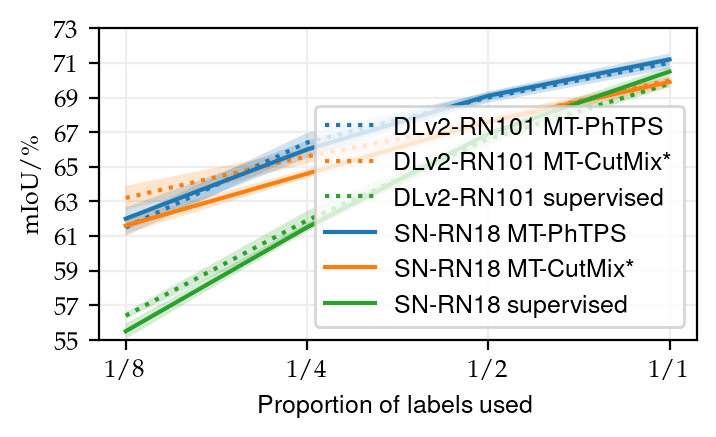

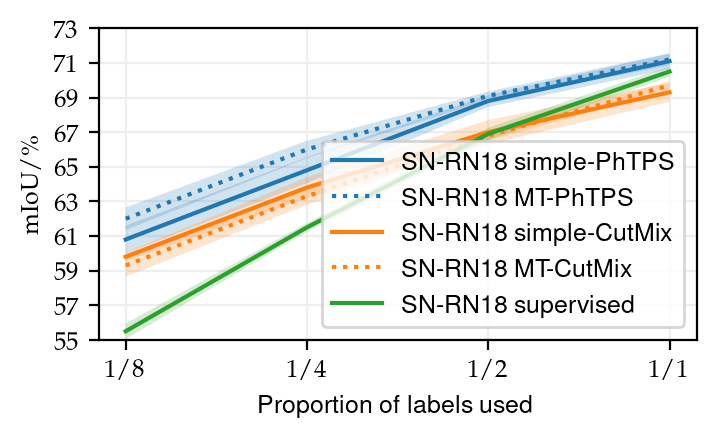

In [5]:

fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_models.keys()}, name_to_style_models, ylim=[55, 73])
fig.savefig('./data/plots/cs-half-sn-dl.pdf')
fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_ssl.keys()}, name_to_style_ssl, ylim=[55, 73])
fig.savefig('./data/plots/cs-half-ssl.pdf')

### Half-resolution Cityscapes - perturbation model ablation

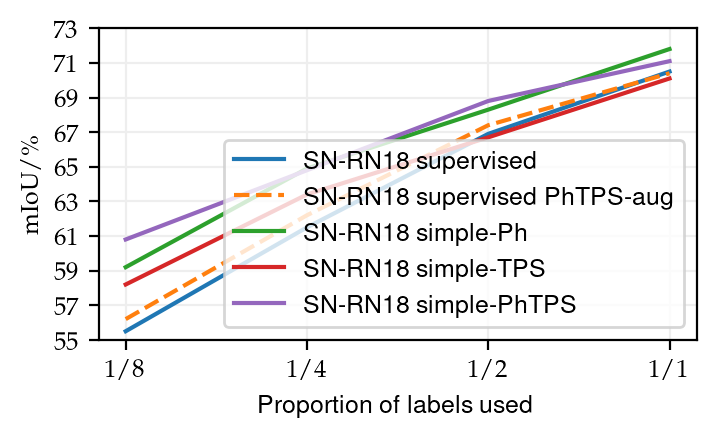

In [6]:
name_to_values = {
    "SN-RN18 supervised"          : [55.5, 61.5, 66.9, 70.5],
    "SN-RN18 supervised PhTPS-aug": [56.2, 62.2, 67.4, 70.4],
    "SN-RN18 simple-Ph"           : [59.2, 64.9, 68.3, 71.8],
    "SN-RN18 simple-TPS"          : [58.2, 63.4, 66.7, 70.1],
    "SN-RN18 simple-PhTPS"        : [60.8, 64.8, 68.8, 71.1],
}
name_to_style = {
    "SN-RN18 supervised"          : dict(color='C0'),
    "SN-RN18 supervised PhTPS-aug": dict(color='C1', linestyle='dashed'),
    "SN-RN18 simple-Ph"           : dict(color='C2'),
    "SN-RN18 simple-TPS"          : dict(color='C3'),
    "SN-RN18 simple-PhTPS"        : dict(color='C4'),
}

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[55, 73])
fig.savefig('./data/plots/cs-half-ablation.pdf')

### Full resolution Cityscapes

In [7]:
name_to_values = {
    "DLv3+-RN50 supervised": [63.9, 68.3, 71.2, 76.3],
    "DLv3+-RN50 CAC"       : [70.1, 72.4, 74.0, 76.5],
    "SN-RN18 supervised"   : [ms(61.1, 0.4), ms(67.3, 1.1), ms(71.9, 0.1), ms(75.4, 0.4)],
    "SN-RN18 simple-PhTPS" : [ms(66.3, 1.0), ms(71.0, 0.5), ms(74.3, 0.7), ms(75.8, 0.4)],
    "SN-RN18 MT-PhTPS"     : [ms(68.6, 0.6), ms(72.0, 0.3), ms(73.8, 0.4), ms(75.0, 0.4)],
    "SN-RN34 supervised"   : [ms(64.9, 0.8), ms(69.8, 1.0), ms(73.8, 1.4), ms(76.1, 0.8)],
    "SN-RN34 simple-PhTPS" : [ms(69.2, 0.8), ms(73.1, 0.7), ms(76.3, 0.7), ms(77.9, 0.2)],
    "SN-RN34 MT-PhTPS"     : [ms(70.8, 1.5), ms(74.3, 0.5), ms(76.0, 0.5), ms(77.2, 0.4)],
}

name_to_style_dl_sn = {
    "DLv3+-RN50 CAC"       : dict(color='C2', linestyle='dashed', alpha=0.5),
    "SN-RN18 simple-PhTPS" : dict(color='C0'),
    "SN-RN18 MT-PhTPS"     : dict(color='C0', linestyle='dotted'),
    "SN-RN34 simple-PhTPS" : dict(color='C1'),
    "SN-RN34 MT-PhTPS"     : dict(color='C1', linestyle='dotted'),
}

name_to_style_all = {
    "DLv3+-RN50 supervised": dict(color='C2', alpha=0.5),
    "DLv3+-RN50 CAC"       : dict(color='C2', linestyle='dashed', alpha=0.5),
    "SN-RN18 supervised"   : dict(color='C0'),
    "SN-RN18 simple-PhTPS" : dict(color='C0', linestyle='dashed'),
    "SN-RN18 MT-PhTPS"     : dict(color='C0', linestyle='dotted'),
    "SN-RN34 supervised"   : dict(color='C1'),
    "SN-RN34 simple-PhTPS" : dict(color='C1', linestyle='dashed'),
    "SN-RN34 MT-PhTPS"     : dict(color='C1', linestyle='dotted'),
}

name_to_style1 = {
    "DLv3+-RN50 supervised": dict(color='C2', alpha=0.5),
    "DLv3+-RN50 CAC"       : dict(color='C2', linestyle='dashed', alpha=0.5),
    "SN-RN18 supervised"   : dict(color='C0'),
    "SN-RN18 simple-PhTPS" : dict(color='C0', linestyle='dashed'),
    "SN-RN18 MT-PhTPS"     : dict(color='C0', linestyle='dotted'),
}

fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_dl_sn}, name_to_style_dl_sn, ylim=[62, 78])
fig.savefig('./data/plots/cs-full-ssl.pdf')
#fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_all}, name_to_style_all, ylim=[62, 78])
#fig.savefig('./data/plots/cs-full2.pdf')

for i, nts in enumerate([name_to_style1, name_to_style_all]):
    fig = plot_label_subsets({k: name_to_values[k] for k in nts}, nts, ylim=[62, 78])
    fig.savefig(f'./data/plots/cs-full{i}.pdf')

KeyboardInterrupt: 

### Half-resolution Cityscapes: consistency loss weight $\alpha$ validation

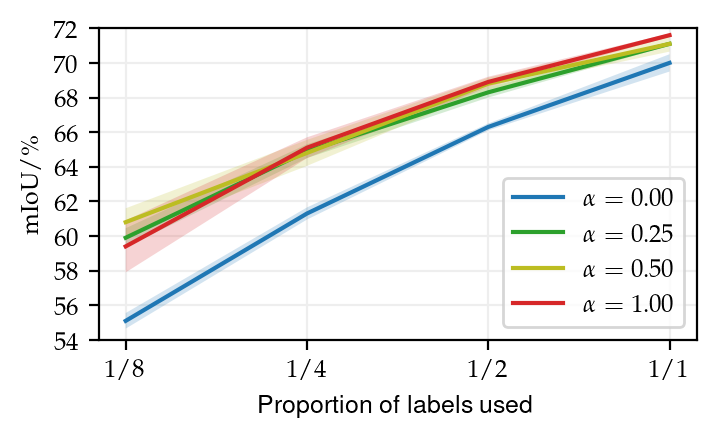

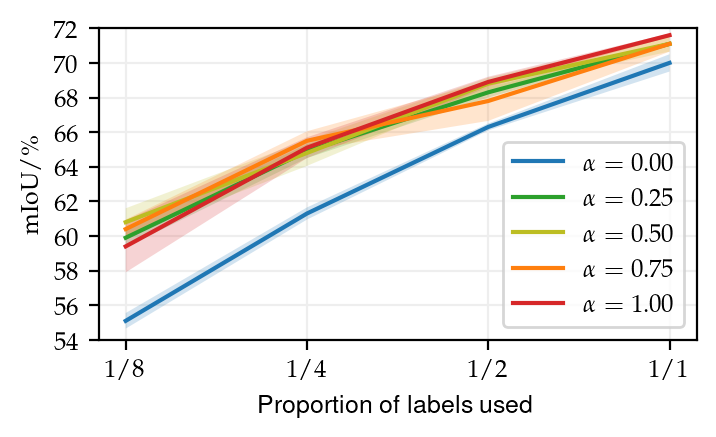

In [ ]:
name_to_values = {
    r"$\alpha=0.00$": [ms(55.1, 0.9), ms(61.3, 0.7),
                       ms(66.3, 0.4), ms(70.0, 1.0)],
    r"$\alpha=0.25$": [ms(59.9, 1.1), ms(64.9, 0.8),
                       ms(68.3, 0.6), ms(71.1, 0.2)],
    r"$\alpha=0.50$": [ms(60.8, 1.6), ms(64.8, 1.5),
                       ms(68.8, 0.7), ms(71.1, 0.9)],
    r"$\alpha=0.75$": [ms(60.4, 1.1), ms(65.5, 1.1),
                       ms(67.8, 2.3), ms(71.1, 0.9)],
    r"$\alpha=1.00$": [ms(59.4, 3.0), ms(65.1, 1.2),
                       ms(68.9, 0.6), ms(71.6, 0.2)]}

colors = plt.cm.jet(np.linspace(0, 1, len(name_to_values)))[::-1]

name_to_style = {
    r"$\alpha=0.00$": dict(color='tab:blue'),
    r"$\alpha=0.25$": dict(color='tab:green'),
    r"$\alpha=0.50$": dict(color='tab:olive'),
    r"$\alpha=0.75$": dict(color='tab:orange'),
    r"$\alpha=1.00$": dict(color='tab:red')}

fig = plot_label_subsets({k: v
                          for k, v in name_to_values.items() if '0.75' not in k}, name_to_style,
                         ylim=[54, 72], legend_loc='lower right')
fig = plot_label_subsets(name_to_values, name_to_style,
                         ylim=[54, 72])
fig.savefig('./data/plots/cs-half-ablation-alpha.pdf')

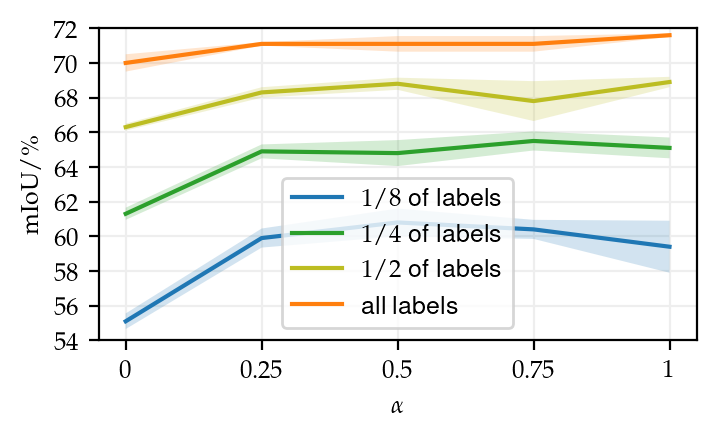

In [ ]:

label_proportions = ["$1/8$ of labels", "$1/4$ of labels", "$1/2$ of labels", "all labels"]
name_to_values_ = {lp: [name_to_values[k][i] for k in name_to_values] for i, lp in enumerate(label_proportions)}
name_to_style_ = dict(zip(label_proportions, name_to_style.values()))

fig = plot_label_subsets(name_to_values_, name_to_style_, ylim=[54, 72], xlabel=r"$\alpha$", xticks=["$0$", "$0.25$", "$0.5$", "$0.75$", "$1$"], legend_loc='lower center')
fig.savefig('./data/plots/cs-half-ablation-alpha-alt.pdf')

## Batch normalization statistics updating in perturbed students - ablation

### Half-resolution Cityscapes

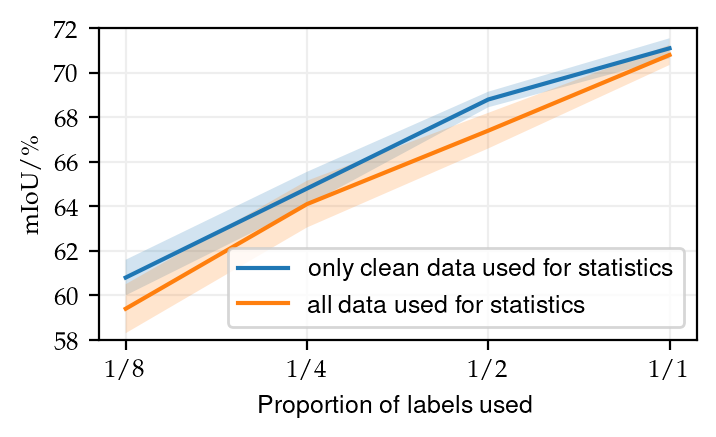

In [ ]:
name_to_values = {
    r"only clean data used for statistics":
    [ms(60.8, 1.6), ms(64.8, 1.5), ms(68.8, 0.7),
     ms(71.1, 0.9)],
    r"all data used for statistics": [ms(59.4, 2.2),
                                      ms(64.1, 2.1),
                                      ms(67.4, 1.6),
                                      ms(70.8, 0.9)], }
name_to_style = {
    r"only clean data used for statistics": dict(color='C0'),
    r"all data used for statistics": dict(color='C1'), }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[58, 72], legend_loc='lower right')
fig.savefig('./data/plots/cs-half-ablation-bn-stats-upd.pdf')

### Cityscapes

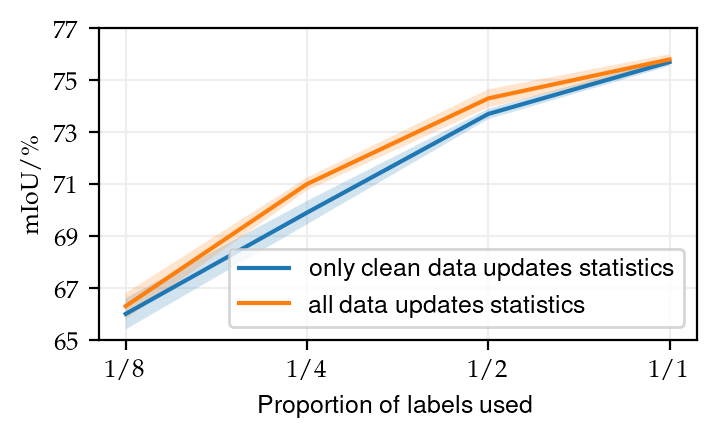

In [ ]:
name_to_values = {
    r"only clean data updates statistics":
    [ms(66.0, 1.2), ms(69.9, 0.9), ms(73.7, 0.4),
     ms(75.7, 0.3)],
    r"all data updates statistics": [ms(66.3, 1.0),
                                      ms(71.0, 0.5),
                                      ms(74.3, 0.7),
                                      ms(75.8, 0.4)], }
name_to_style = {
    r"only clean data updates statistics": dict(color='C0'),
    r"all data updates statistics": dict(color='C1'), }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[65, 77], legend_loc='lower right')
fig.savefig('./data/plots/cs-ablation-bn-stats-upd.pdf')

### CIFAR-10

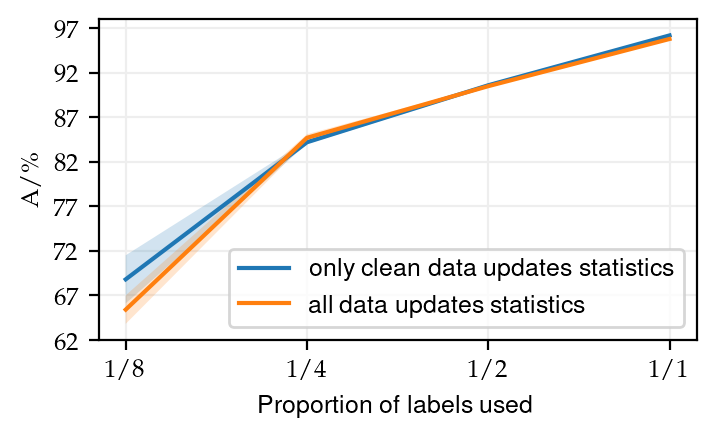

In [ ]:
name_to_values = {
    r"only clean data updates statistics":
    [ms(68.8, 5.4), ms(84.2, 0.4), ms(90.6, 0.4),
     ms(96.2, 0.2)],
    r"all data updates statistics": [ms(65.4, 3.2),
                                     ms(84.7, 0.8),
                                     ms(90.5, 0.2),
                                     ms(95.8, 0.2)], }
name_to_style = {
    r"only clean data updates statistics": dict(color='C0'),
    r"all data updates statistics": dict(color='C1'), }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[62, 98], ylabel='$\mathrm{A}/\%$', legend_loc='lower right')
fig.savefig('./data/plots/cifar10-ablation-bn-stats-upd.pdf')

## half-resolution Cityscapes, 1/4 of labels, perturbation strength validation

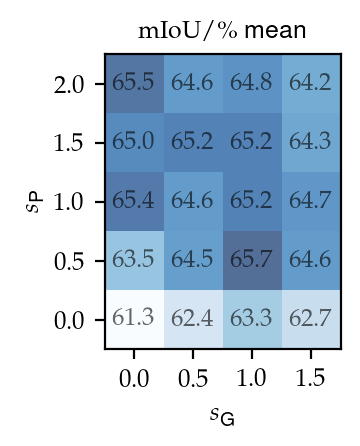

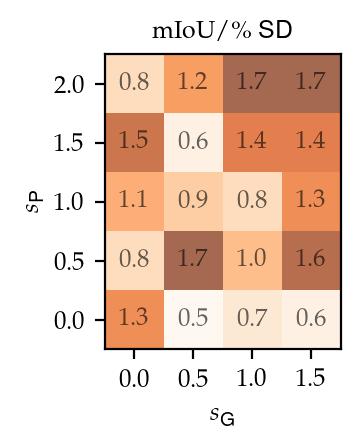

In [ ]:
pert_validation_grid_means = np.array([[.613, .624, .633, .627], [.635, .645, .657, .646],
                                       [.654, .646, .652, .647], [.650, .652, .652, .643],
                                       [.655, .646, .648, .642]])*100
pert_validation_grid_stdevs = np.array([[.013, .005, .007, .006], [.008, .017, .010, .016],
                                        [.011, .009, .008, .013], [.015, .006, .014, .014],
                                        [.008, .012, .017, .017]])*100


def plot_grid(matrix, xticks, yticks, xlabel, ylabel, cmap='RdYlGn', title=None, center_cmap=False):
    fig, ax = plt.subplots(figsize=(2.3, 2.3))

    mean = matrix.mean()

    ax.matshow(matrix - mean if center_cmap else matrix, cmap=cmap, alpha=0.7)

    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[0]):
            c = matrix[j, i]
            ax.text(i, j, f"${c:.1f}$".lstrip('0'), va='center', ha='center',
                    weight='semibold', color='black', alpha=0.6)
    plt.xticks(range(matrix.shape[1]), xticks)  #, rotation=90)
    plt.yticks(range(matrix.shape[0]), yticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position("bottom")
    #ax.xaxis.set_label_position("top")
    fig.tight_layout()
    return fig


xticks = [f'${i*0.5:.1f}$' for i in range(4)]
yticks = [f'${i*0.5:.1f}$' for i in range(5)]
fig = plot_grid(pert_validation_grid_means, xticks=xticks, yticks=yticks, xlabel=r"$s_\text{G}$",
          ylabel=r"$s_\text{P}$", center_cmap=False, cmap='Blues', title="$\mathrm{mIoU}/\%$ mean")
fig.savefig('./data/plots/cs-half-pert-validation-grid.pdf', bbox_inches='tight')
fig = plot_grid(pert_validation_grid_stdevs, xticks=xticks, yticks=yticks, xlabel=r"$s_\text{G}$",
          ylabel=r"$s_\text{P}$", cmap='Oranges', title="$\mathrm{mIoU}/\%$ SD")
fig.savefig('./data/plots/cs-half-pert-validation-grid-stds.pdf', bbox_inches='tight')

In [ ]:
def handler(state):
    def _generate_results(results, class_colors, dir="/tmp/semisup", common_prefix="",
                          common_suffix="", method_suffix=""):
        import vidlu.utils.presentation.visualization as vis
        import vidlu.transforms.image as vti

        if common_prefix != "":
            common_prefix = f"{common_prefix}_"
        if common_suffix != "":
            common_suffix = f"_{common_suffix}"
        if method_suffix != "":
            method_suffix = f"_{method_suffix}"
        dir = Path(dir)

        results = {
            k: v.argmax(1) if k.startswith('out') else v
            for k, v in results.items() if k.startswith('x') or k.startswith('out')}
        results = {k: v.detach().cpu() for k, v in results.items()}
        results = {
            k: (vti.chw_to_hwc(v.clamp(0, 1)) if v.shape[1] == 3 else v).numpy()
            for k, v in results.items()}

        colors = vis.normalize_colors(class_colors, insert_zeros=True)
        for k, v in results.items():
            if v.shape[-1] != 3:
                v = vis.colorize_segmentation(v + 1, colors)
            ims = [vti.numpy_to_pil((im * 255).astype(np.uint8)) for im in v]
            for i, im in enumerate(ims):
                path = dir / f"{common_prefix}{i:04}_{k}{common_suffix}.png"
                print(path)
                im.save(path)

        return results

    from vidlu.data.datasets import Cityscapes
    if state.iteration == 0:
        _generate_results(dir='/mnt/sdc1/igrubisic/semisup',
                          class_colors=Cityscapes.info.class_colors, results=state.result,
                          common_prefix=f"{state.epoch:04}_{state.iteration:03}")


trainer.training.iter_completed.add_handler(handler)
#from vidlu.utils.debug import state as ctx
#key = 'trainingfig'
#if key not in ctx:
#   ctx[key] = dict(sup=state.batch[0].name, semisup=state.batch[1].name)


NameError: name 'trainer' is not defined